In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from flydance.io.smart_loader import FlyData
from flydance.vr.neuser import NeuserParams
from flydance.vr.neuser import FollowBarWatch
import sys
import os
sys.path.append("/Users/ambra-stella/flydance/experiments")

In [13]:
fname = "/Users/ambra-stella/bachelor/analysis/wt/clipped_reaction.csv" # SPECIFY WHAT DISTRACTOR LIST
clipped_reaction = pd.read_csv(fname)
print(clipped_reaction.columns)

Index(['frame', 'timestamp', 'x', 'y', 'xvel', 'yvel', 't', 'x_px', 'y_px',
       'orientation_radians_mod_pi', 'contrast', 'luminance', 'center_x',
       'center_y', 'stage', 'direction', 'ON', 'direction_change',
       'area_change', 'area', 'stopped', 'ntimes', 'distraction_index',
       'fly_number', 'timing'],
      dtype='object')


# This updates 'stopped' & deletes rows where the fly is not moving:

In [14]:
clipped_reaction['speed'] = np.sqrt((clipped_reaction.xvel)**2+(clipped_reaction.yvel)**2) 
clipped_reaction.stopped = clipped_reaction.speed <= 0.01
clipped_reaction = clipped_reaction.loc[clipped_reaction.stopped != 1]
#clipped_reaction

# lists all flies, and the number of flies:

In [15]:
list_flies = clipped_reaction['fly_number'].tolist()
list_flies = set(list_flies)
list_flies = list(list_flies)
print('flies with valid runns:', list_flies)
print('Number of flies:', len(list_flies))

flies with valid runns: ['20210618_144402', '20210615_160518', '20210621_144554', '20210615_183832', '20210616_151740', '20210616_150754', '20210623_124454', '20210628_173232', '20210629_172133']
Number of flies: 9


# maximum number of distraction bars visible to at least on fly:

In [16]:
list_distraction_index = clipped_reaction['distraction_index'].tolist()
list_distraction_index = set(list_distraction_index)
list_distraction_index = list(list_distraction_index)
#print(list_distraction_index)
print('max distractions a fly had:', len(list_distraction_index), list_distraction_index)

max distractions a fly had: 7 [0, 1, 2, 3, 4, 5, 6]


# number of total trajetories:

In [17]:
traj_count = 0
for flies in list_flies:
    piece = clipped_reaction[(clipped_reaction.fly_number == flies) & (clipped_reaction.timing == 'after')]
    for index in list_distraction_index:
        smaller_piece = piece.loc[piece.distraction_index == index]
        if smaller_piece.empty:
                pass
        else:
            traj_count = traj_count +1
            #for i, row in smaller_piece.iterrows():
            #    testout= after_direction(row)
print('total trajectories:', traj_count)

total trajectories: 18


# creates smaller df for the before, while and after the distraction:

In [18]:
bar_frame = clipped_reaction.loc[clipped_reaction.timing == 'bar'].copy()
before_frame = clipped_reaction.loc[clipped_reaction.timing == 'before'].copy()
after_frame = clipped_reaction.loc[clipped_reaction.timing == 'after'].copy()


# Creates the mean angle while bar is shown: 

In [19]:
clipped_reaction['mean_angle'] = ''
for flies in list_flies:
    piece = bar_frame[bar_frame.fly_number == flies]
    for index in list_distraction_index:
        smaller_piece = piece[piece.distraction_index == index]
        xvec = (smaller_piece.xvel).sum() 
        yvec = (smaller_piece.yvel).sum()
        mean_angle  = np.arctan2(yvec,xvec)
        if mean_angle != 0:
            clipped_reaction.loc[(clipped_reaction.fly_number == flies) & (clipped_reaction.distraction_index == index) & (clipped_reaction.timing == 'bar'), 'mean_angle'] = mean_angle 

# Creates the mean angle before bar is shown: 

In [20]:
for flies in list_flies:
    piece = before_frame[before_frame.fly_number == flies]
    for index in list_distraction_index:
        smaller_piece = piece[piece.distraction_index == index]
        xvec = (smaller_piece.xvel).sum() 
        yvec = (smaller_piece.yvel).sum()
        mean_angle  = np.arctan2(yvec,xvec)
        if mean_angle != 0:
            clipped_reaction.loc[(clipped_reaction.fly_number == flies) & (clipped_reaction.distraction_index == index) & (clipped_reaction.timing == 'before'), 'mean_angle'] = mean_angle

# Creates the mean angle after bar is shown: 

In [35]:
for flies in list_flies:
    piece = after_frame[(after_frame.fly_number == flies)]
    for index in list_distraction_index:
        smaller_piece = piece[piece.distraction_index == index]
        xvec = (smaller_piece.xvel).sum() 
        yvec = (smaller_piece.yvel).sum()
        mean_angle  = np.arctan2(yvec,xvec)
        if mean_angle != 0:
            clipped_reaction.loc[(clipped_reaction.fly_number == flies) & (clipped_reaction.distraction_index == index) & (clipped_reaction.timing == 'after'), 'mean_angle'] = mean_angle

In [22]:
#clipped_reaction

# setts empty lists to 0 value to be able to work with it:

In [23]:
clipped_reaction = clipped_reaction.replace(to_replace ="", value =0.000)
clipped_reaction['mean_angle'].unique()

array([-3.13473433,  0.        ,  2.84551287,  1.45312353,  3.10112232,
        3.05179959,  1.3483551 , -0.13701952, -0.09121557,  0.4439726 ,
        2.91287784, -1.80709215,  0.44202635,  1.99469331, -2.84845556,
        0.56182589,  0.21806858,  0.08803557, -1.235665  ,  2.99984935,
       -3.05239853, -3.05655316,  0.51199751,  1.22472946, -0.76988911,
       -0.78573486, -3.07326989,  1.95361428,  0.14775569, -0.42267054,
       -1.72251593,  2.82713361, -2.53132553,  2.88121778,  2.59106432,
       -2.52868501, -2.31291625,  2.4488195 , -2.22654672, -2.06896347,
       -2.99972312, -1.89212481,  0.39554577, -2.87998493, -2.69214588,
        2.10019407,  0.45870096, -0.53495117, -2.04560626, -0.08712126,
       -0.75304291, -1.59556628])

# new row 'reaction_direction' : up, down, other (55° WAY):
maybe shorten the time? first second?

In [24]:
#clipped_reaction['reaction_direction'] = ''


#clipped_reaction.loc[(clipped_reaction.timing == 'bar') & (clipped_reaction.mean_angle >= 1.090830) & (clipped_reaction.mean_angle <= 2.050761), 'reaction_direction'] = 'up'
 
#clipped_reaction.loc[(clipped_reaction.timing == 'bar') & (clipped_reaction.mean_angle <= -1.090830) & (clipped_reaction.mean_angle >= -2.050761), 'reaction_direction'] = 'down'

#clipped_reaction.loc[(clipped_reaction.timing == 'bar') & (clipped_reaction.reaction_direction == ''), 'reaction_direction'] = 'other'


# names up, down, other reaction while the bar was shown (55° WAY, but the last segment):


In [25]:
right_rad = 1.090830
right_rad = float(right_rad)
#print(type(up_rad))
left_rad = 2.050761
left_rad = float(left_rad)

for flies in list_flies:
    piece = clipped_reaction[(clipped_reaction.fly_number == flies) & (clipped_reaction.timing == 'bar')]
    for index in list_distraction_index:
        smaller_piece = piece[piece.distraction_index == index]
        #print(index)
        
        if smaller_piece.empty:
            pass
        else: 
            segment =  smaller_piece[-15:]  #60 rather than 30 frames (for 1s [30fs]) because double the lines
        
            xvec = (segment.xvel).sum() 
            yvec = (segment.yvel).sum()
            angle  = np.arctan2(yvec,xvec)
            
            
            #print(angle)
            
            if (angle > 0) & (angle <= left_rad) & (angle >= right_rad): #positiv
                #print ('positiv bitch be going up')
                clipped_reaction.loc[(clipped_reaction.timing == 'bar') & (clipped_reaction.distraction_index == index) & (clipped_reaction.fly_number == flies), 'reaction_direction'] = 'up'
                    
                    
            elif (angle < 0) & (angle >= -left_rad) & (angle <= -right_rad): #negativ
                #print ('negativ bitch be going down')
                clipped_reaction.loc[(clipped_reaction.timing == 'bar') & (clipped_reaction.distraction_index == index) & (clipped_reaction.fly_number == flies), 'reaction_direction'] = 'down'
            
            else: 
                clipped_reaction.loc[(clipped_reaction.timing == 'bar') & (clipped_reaction.distraction_index == index) & (clipped_reaction.fly_number == flies), 'reaction_direction'] = 'other'

In [26]:
clipped_reaction['reaction_direction'].value_counts()

other    1209
up        362
down      196
Name: reaction_direction, dtype: int64

In [27]:
clipped_reaction = clipped_reaction.replace(to_replace ='', value =0.000)
clipped_reaction['reaction_direction'].unique()

array([nan, 'other', 'up', 'down'], dtype=object)

# sortes if the fly goes right or left afterwards (first)

for flies in list_flies:
    piece = clipped_reaction[(clipped_reaction.fly_number == flies) & (clipped_reaction.timing == 'after')]
    for index in list_distraction_index:
        smaller_piece = piece.loc[piece.distraction_index == index]
        last = smaller_piece[-1:].reset_index(drop=True)
        #print('last:', last)
       
        if last.empty:
            pass
        else: 
            right_rad = last['last_bar_direc'] - 0.785398
            right_rad = float(right_rad)
            #print('last_bar_direc:', last['last_bar_direc'])
            #print('right rad:', right_rad)
            left_rad = last['last_bar_direc'] + 0.785398
            left_rad = float(left_rad)
            #print('left rad:', left_rad)
        
            after_angle = clipped_reaction.loc[clipped_reaction.timing == 'after'].mean_angle
            after_angle = after_angle[-1:].reset_index(drop=True)
            after_angle = float(after_angle)
            #print ('after angle:',after_angle)
        
            if after_angle <= right_rad: 
                #print('it fucking works RIGHT')
                clipped_reaction.loc[(clipped_reaction.timing == 'after') & (clipped_reaction.distraction_index == index) & (clipped_reaction.fly_number == flies), 'reaction_direction'] = 'right'
            
            elif after_angle >= left_rad: 
                #print('it fucking works LEFT')
                clipped_reaction.loc[(clipped_reaction.timing == 'after') & (clipped_reaction.distraction_index == index) & (clipped_reaction.fly_number == flies), 'reaction_direction'] = 'left'
            
            else:  
                clipped_reaction.loc[(clipped_reaction.timing == 'after') & (clipped_reaction.distraction_index == index) & (clipped_reaction.fly_number == flies), 'reaction_direction'] = 'other'
                #print('it couldnt fucking decide')
            

# sortes if the fly goes right or left afterwards:

In [28]:
use_df = clipped_reaction

for flies in list_flies:
        after_piece = use_df[(use_df.fly_number == flies) & (use_df.timing == 'after')]
        #print('after_piece:', after_piece[:6])
        bar_piece = use_df[(use_df.fly_number == flies) & (use_df.timing == 'bar')]
        #print('bar_piece:', bar_piece[:6])
        #print('fly:', flies)
        for index in list_distraction_index:
                after_smaller_piece = after_piece.loc[after_piece.distraction_index == index]
                #print('after_smaller_piece:', after_smaller_piece[:6])
                bar_smaller_piece = bar_piece.loc[bar_piece.distraction_index == index]
                #print('bar_smaller_piece:', bar_smaller_piece[:6])
                #print('index:', index)
                
                if after_smaller_piece.empty | bar_smaller_piece.empty:
                        pass
                else:
                
                        last_bar_segment =  bar_smaller_piece[-15:]  
                        xvec = (last_bar_segment.xvel).sum() 
                        yvec = (last_bar_segment.yvel).sum()
                        last_bar_angle  = np.arctan2(yvec,xvec)
                        #print('last_bar_angle:', last_bar_angle)
                        
                        right_rad = last_bar_angle - 0.785398
                        #right_rad = float(right_rad)
                        #print('right rad:', right_rad)
                        left_rad = last_bar_angle + 0.785398
                        #left_rad = float(left_rad)
                        #print('left rad:', left_rad)
                
                
                        for chunk in np.array_split(after_smaller_piece, len(after_smaller_piece)//5):
                                #print('chunk size:', len(chunk))
                                just_vel = chunk[['xvel','yvel']]
                                #print('the velocity chunk is:', just_vel)
                                xvec = (chunk.xvel).sum() 
                                yvec = (chunk.yvel).sum()
                                chunk_angle  = np.arctan2(yvec,xvec)
                                #print('chunk angle:', chunk_angle)
                                
                                if last_bar_angle > 0: #POSITIV
                                        if chunk_angle < right_rad: #SMALLER
                                                #print('right')
                                                clipped_reaction.loc[(clipped_reaction.timing == 'after') & (clipped_reaction.distraction_index == index) & (clipped_reaction.fly_number == flies), 'reaction_direction'] = 'right'
                                                break
                                        
                                        elif chunk_angle > left_rad: #BIGGER
                                                #print('left')
                                                clipped_reaction.loc[(clipped_reaction.timing == 'after') & (clipped_reaction.distraction_index == index) & (clipped_reaction.fly_number == flies), 'reaction_direction'] = 'left'
                                                break
                        
                                elif last_bar_angle < 0: #NEGATIV
                                        if chunk_angle > left_rad: #BIGGER
                                                #print('right')
                                                clipped_reaction.loc[(clipped_reaction.timing == 'after') & (clipped_reaction.distraction_index == index) & (clipped_reaction.fly_number == flies), 'reaction_direction'] = 'right'
                                                break
                                        elif chunk_angle < right_rad: #SMALLER
                                                #print('left')
                                                clipped_reaction.loc[(clipped_reaction.timing == 'after') & (clipped_reaction.distraction_index == index) & (clipped_reaction.fly_number == flies), 'reaction_direction'] = 'left'
                                                break
                                else:
                                        #print('no decition')
                                        clipped_reaction.loc[(clipped_reaction.timing == 'after') & (clipped_reaction.distraction_index == index) & (clipped_reaction.fly_number == flies), 'reaction_direction'] = 'other'

In [34]:
test = clipped_reaction[clipped_reaction.reaction_direction == 'other']
test['timing'].unique()

array(['bar'], dtype=object)

# looks for 'before direction':

In [30]:
up_rad = 1.570796
up_rad = float(up_rad)
print(type(up_rad))
down_rad = -1.570796
down_rad = float(down_rad)

for flies in list_flies:
    piece = clipped_reaction[(clipped_reaction.fly_number == flies) & (clipped_reaction.timing == 'before')]
    for index in list_distraction_index:
        smaller_piece = piece[piece.distraction_index == index]
        smaller_piece = smaller_piece[-1:]
        smaller_piece = smaller_piece[-1:].reset_index(drop=True)
        angle = smaller_piece.mean_angle
        #print (smaller_piece.mean_angle)
        
        if smaller_piece.empty:
            pass
        else: 
           
            angle = float(angle)
            #print(angle)
            
            if angle > 0:
                if angle < up_rad:
                    #print('right')
                    clipped_reaction.loc[(clipped_reaction.timing == 'before') & (clipped_reaction.distraction_index == index) & (clipped_reaction.fly_number == flies), 'reaction_direction'] = 'right'
                elif angle > up_rad:
                    #print('left')
                    clipped_reaction.loc[(clipped_reaction.timing == 'before') & (clipped_reaction.distraction_index == index) & (clipped_reaction.fly_number == flies), 'reaction_direction'] = 'left'
                    
                    
            elif angle < 0:
                if angle < down_rad:
                    #print('left')
                    clipped_reaction.loc[(clipped_reaction.timing == 'before') & (clipped_reaction.distraction_index == index) & (clipped_reaction.fly_number == flies), 'reaction_direction'] = 'left'
                elif angle > down_rad:
                    #print('right')
                    clipped_reaction.loc[(clipped_reaction.timing == 'before') & (clipped_reaction.distraction_index == index) & (clipped_reaction.fly_number == flies), 'reaction_direction'] = 'right'
            else:
                clipped_reaction.loc[(clipped_reaction.timing == 'before') & (clipped_reaction.distraction_index == index) & (clipped_reaction.fly_number == flies), 'reaction_direction'] = 'other'
    

<class 'float'>


# saves the df in this directory (DONT FORGET TO CHANGE NAME!!!):

In [31]:
#clipped_reaction.to_csv("/Users/ambra-stella/bachelor/analysis/wt/reaction_summary.csv", index=False)

# Visualizer:


(-0.1, 0.1)

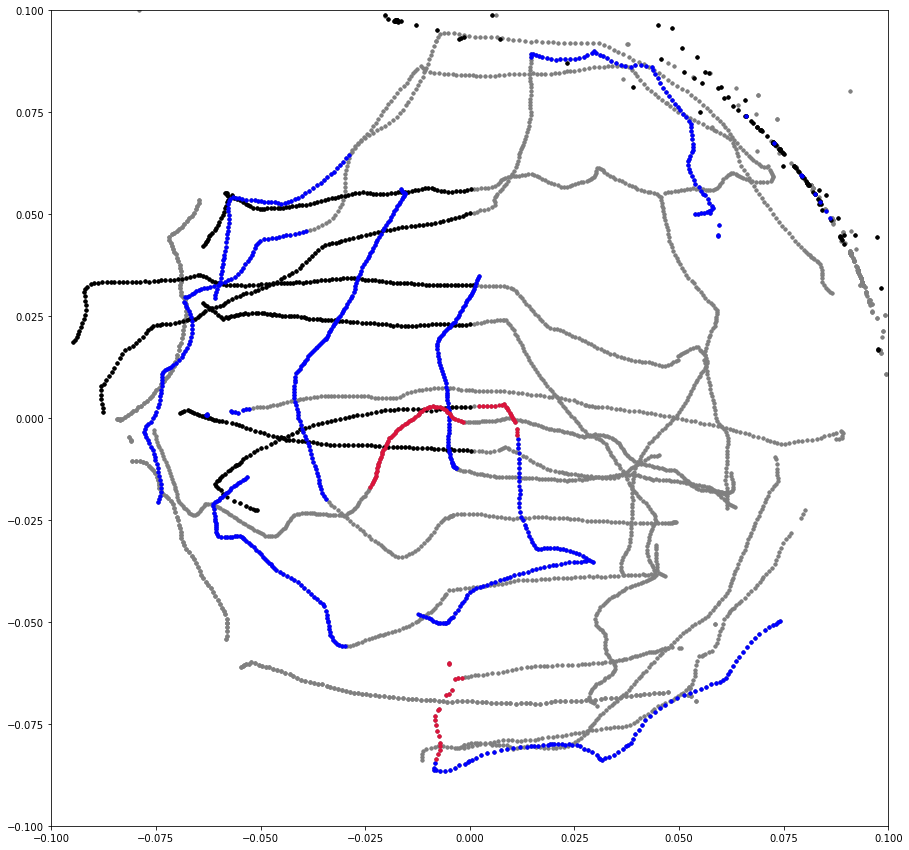

In [32]:
beginning_direc = 'right'   ## BLACK
bar_direc = 'down'          ## CRIMSON
end_direc = 'right'         ## BLUE



plt.figure(figsize=(15,15))
for flies in list_flies:
    piece = clipped_reaction[(clipped_reaction.fly_number == flies)]
    for index in list_distraction_index:
        smaller_piece = piece[piece.distraction_index == index]
        plt.plot(smaller_piece.x, smaller_piece.y, '.', color= 'gray')
        #sns.scatterplot(data=smaller_piece, x=smaller_piece.x, y=smaller_piece.y)
plt.plot(clipped_reaction[(clipped_reaction.reaction_direction == beginning_direc) & (clipped_reaction.timing == 'before')].x, clipped_reaction[(clipped_reaction.reaction_direction ==beginning_direc)&(clipped_reaction.timing == 'before') ].y, '.', color= 'k')
plt.plot(clipped_reaction[(clipped_reaction.reaction_direction == end_direc) & (clipped_reaction.timing == 'after')].x, clipped_reaction[(clipped_reaction.reaction_direction == end_direc)&(clipped_reaction.timing == 'after') ].y, '.',color= 'blue')
plt.plot(clipped_reaction[(clipped_reaction.reaction_direction == bar_direc) & (clipped_reaction.timing == 'bar')].x, clipped_reaction[(clipped_reaction.reaction_direction ==bar_direc)&(clipped_reaction.timing == 'bar') ].y, ('.'), color= 'crimson')
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)
#plt.axis('equal');


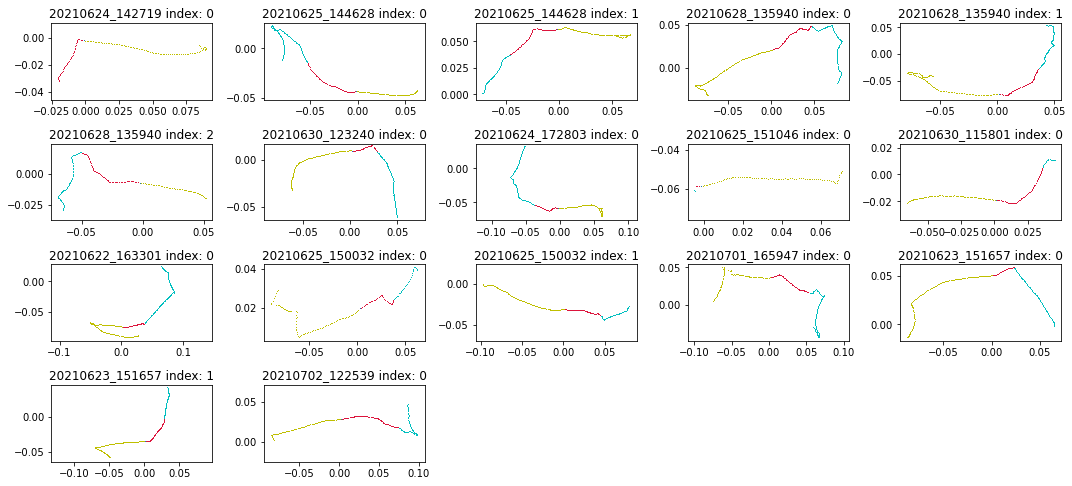

In [195]:
count= 1
fig = plt.figure(figsize=(15,15))
for flies in list_flies:
    piece = clipped_reaction[(clipped_reaction.fly_number == flies)]
    for index in list_distraction_index:
        smaller_piece = piece[piece.distraction_index == index]
        
        if smaller_piece.empty:
            pass
        else:
            ax = fig.add_subplot(9,5,count)
            ax.plot(smaller_piece.x, smaller_piece.y, ',')
            ax.set_title(str(flies)+' index: '+str(index))
            
            ax.plot(smaller_piece[(smaller_piece.timing == 'before')].x, smaller_piece[(smaller_piece.timing == 'before') ].y, ',', color= 'y')
            ax.plot(smaller_piece[(smaller_piece.timing == 'after')].x, smaller_piece[(smaller_piece.timing == 'after') ].y, ',',color= 'c')
            ax.plot(smaller_piece[(smaller_piece.timing == 'bar')].x, smaller_piece[(smaller_piece.timing == 'bar') ].y, (','), color= 'crimson')
            count=count+1
    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.1, 0.1)
    plt.axis('equal')
    plt.tight_layout()
    
#plt.savefig("/Users/ambra-stella/bachelor/analysis/TNTe/TNTe.pdf")


# plotting direction grams:

In [ ]:
timing = 'bar'
fly_numb = '20210621_144554'
dis_index = '0'



plotting_piece = clipped_reaction[(clipped_reaction.fly_number == fly_numb) & (clipped_reaction.timing == timing) & (clipped_reaction.stopped== 0)]
plotting_piece
angle = plotting_piece['mean_angle'].tolist()
angle = set(angle)
print('seted angle:', angle)
angle = list(angle)
print('listed angles:', angle)
plotting_piece['walking_angle'] = np.arctan2(plotting_piece.yvel, plotting_piece.xvel)


ax = plt.subplot(111, polar=True)
ax.hist(plotting_piece.walking_angle, bins=50, facecolor='g')
ax.axvline(angle)